In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
ptbdb_abnormal = '/kaggle/input/heartbeat/ptbdb_abnormal.csv'
ptbdb_normal = '/kaggle/input/heartbeat/ptbdb_normal.csv'
mitbih_test = '/kaggle/input/heartbeat/mitbih_test.csv'
mitbih_train = '/kaggle/input/heartbeat/mitbih_train.csv'

In [4]:
ptbdb_normal = pd.read_csv(ptbdb_normal, header=None)
ptbdb_abnormal = pd.read_csv(ptbdb_abnormal, header=None)
mitbih_train = pd.read_csv(mitbih_train, header=None)
mitbih_test = pd.read_csv(mitbih_test, header=None)

In [5]:
# Display basic information and first few rows
print("PTBDB Abnormal:")
print(ptbdb_abnormal.info())
print(ptbdb_abnormal.head())

print("\nPTBDB Normal:")
print(ptbdb_normal.info())
print(ptbdb_normal.head())

print("\nMIT-BIH Test:")
print(mitbih_test.info())
print(mitbih_test.head())

print("\nMIT-BIH Train:")
print(mitbih_train.info())
print(mitbih_train.head())

PTBDB Abnormal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 15.1 MB
None
        0         1         2         3         4         5         6    \
0  0.932233  0.869679  0.886186  0.929626  0.908775  0.933970  0.801043   
1  1.000000  0.606941  0.384181  0.254237  0.223567  0.276836  0.253430   
2  1.000000  0.951613  0.923963  0.853303  0.791859  0.734255  0.672043   
3  0.977819  0.899261  0.230129  0.032348  0.142329  0.223660  0.328096   
4  0.935618  0.801661  0.805815  1.000000  0.722741  0.480789  0.454829   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.749783  0.687229  0.635100  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.184826  0.153349  0.121872  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.685100  0.670507  0.667435  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.367837  0.381701  0.389094  ...  0.0  0.0  0.0  0.0  

In [6]:
print("PTBDB Abnormal Class Distribution:")
print(ptbdb_abnormal.iloc[:, -1].value_counts())

print("PTBDB Normal Class Distribution:")
print(ptbdb_normal.iloc[:, -1].value_counts())

print("MIT-BIH Train class Distribution:")
print(mitbih_train.iloc[:, -1].value_counts())

print("MIT-BIH Test Class Distribution: ")
print(mitbih_test.iloc[:, -1].value_counts())

PTBDB Abnormal Class Distribution:
187
1.0    10506
Name: count, dtype: int64
PTBDB Normal Class Distribution:
187
0.0    4046
Name: count, dtype: int64
MIT-BIH Train class Distribution:
187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64
MIT-BIH Test Class Distribution: 
187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


In [7]:
ptbdb_abnormal.iloc[0, :-1]

0      0.932233
1      0.869679
2      0.886186
3      0.929626
4      0.908775
         ...   
182    0.000000
183    0.000000
184    0.000000
185    0.000000
186    0.000000
Name: 0, Length: 187, dtype: float64

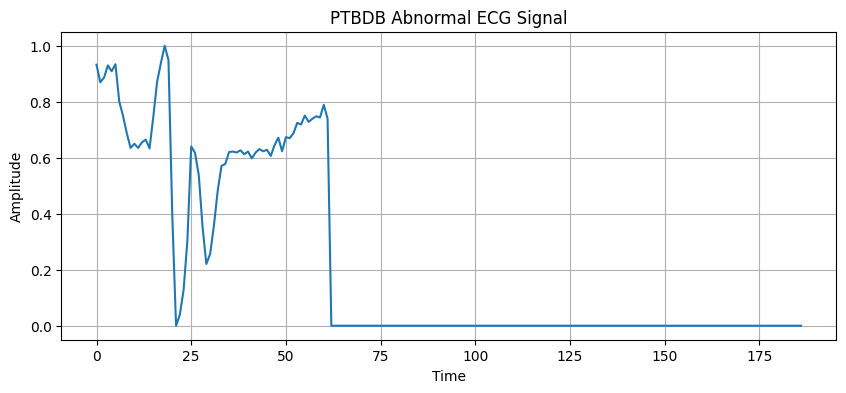

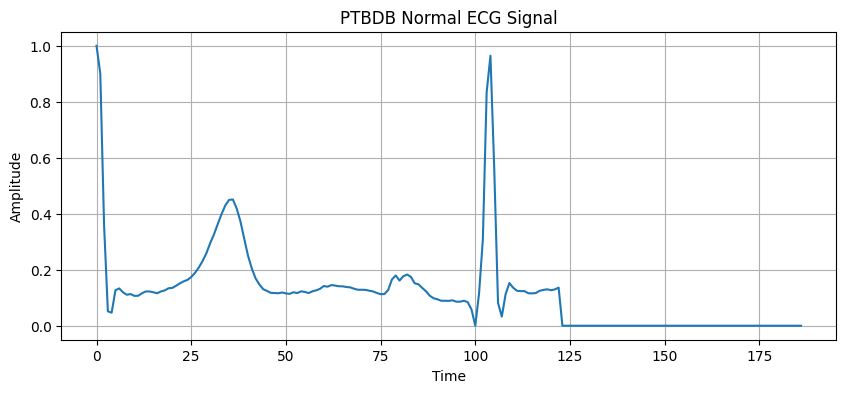

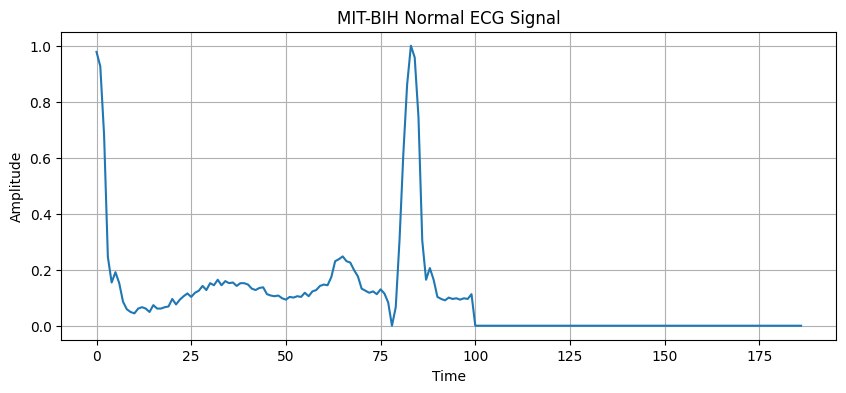

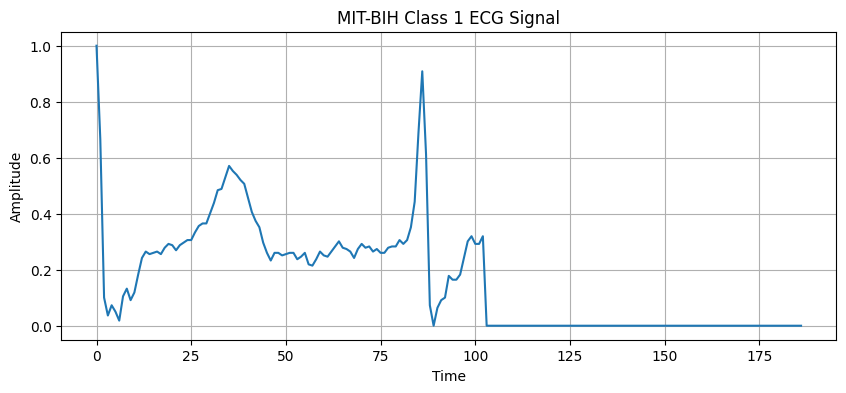

In [8]:
import matplotlib.pyplot as plt

def plot_ecg(signal, title):
    plt.figure(figsize = (10, 4))
    plt.plot(signal)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()
    
# Plotting a few samples from each class
plot_ecg(ptbdb_abnormal.iloc[0, :-1], 'PTBDB Abnormal ECG Signal')
plot_ecg(ptbdb_normal.iloc[0, :-1], 'PTBDB Normal ECG Signal')
plot_ecg(mitbih_train[mitbih_train[187] == 0].iloc[0, :-1],'MIT-BIH Normal ECG Signal')
plot_ecg(mitbih_train[mitbih_train[187] == 1].iloc[0, :-1], 'MIT-BIH Class 1 ECG Signal')


In [9]:
majority = mitbih_train[mitbih_train[187] == 0]
minority = mitbih_train[mitbih_train[187] != 0]
len(minority)

15083

In [10]:
from sklearn.utils import resample 

#separating majority and minority classes
majority = mitbih_train[mitbih_train[187] == 0]
minority = mitbih_train[mitbih_train[187] != 0]

minority_upsampled = resample(minority, 
                             replace = True,
                             n_samples = len(majority),
                             random_state = 123)

mitbih_train_upsampled = pd.concat([majority, minority_upsampled])

print(mitbih_train_upsampled[187].value_counts())

187
0.0    72471
4.0    30962
2.0    27631
1.0    10815
3.0     3063
Name: count, dtype: int64


In [11]:
mitbih_train_upsampled.shape

(144942, 188)

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = mitbih_train_upsampled.drop(columns = [187])
y_train = mitbih_train_upsampled[187]

X_train_scaled = scaler.fit_transform(X_train)

mitbih_train_scaled = pd.DataFrame(X_train_scaled)
mitbih_train_scaled[187] = y_train.values

print(mitbih_train_scaled.head())

        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0 

In [13]:
from sklearn.model_selection import train_test_split
X = mitbih_train_scaled.drop(columns = [187])
y = mitbih_train_scaled[187]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state =42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (115953, 187) (115953,)
Validation set shape: (28989, 187) (28989,)


In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

X_train = X_train.to_numpy() if isinstance(X_train, (pd.DataFrame, pd.Series)) else X_train
y_train = y_train.to_numpy() if isinstance(y_train, (pd.DataFrame, pd.Series)) else y_train
X_val = X_val.to_numpy() if isinstance(X_val, (pd.DataFrame, pd.Series)) else X_val
y_val = y_val.to_numpy() if isinstance(y_val, (pd.DataFrame, pd.Series)) else y_val

if X_train.ndim == 1:
    X_train = np.expand_dims(X_train, axis=1)
if X_val.ndim == 1:
    X_val = np.expand_dims(X_val, axis=1)

train_inputs = torch.tensor(X_train, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.long)

val_inputs = torch.tensor(X_val, dtype=torch.float32)
val_labels = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(train_inputs, train_labels)
val_dataset = TensorDataset(val_inputs, val_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [15]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
import torch.nn as nn


class ECG_CNN(nn.Module):
    def __init__(self, num_classes):
        super(ECG_CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size = 5, stride = 1, padding = 2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size = 5, stride = 1, padding=2)
        
        self.pool = nn.MaxPool1d(kernel_size = 5, stride = 2)
        
        self.global_pool = nn.AdaptiveAvgPool1d(20)
        
        self.fc1 = nn.Linear(256*20, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    


In [17]:
import numpy as np

unique_labels = np.unique(y_train)
num_classes = len(unique_labels)

print(f"Number of classes: {num_classes}")

model = ECG_CNN(num_classes)

Number of classes: 5


In [18]:
import torch
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

num_epochs = 20
model.to(device)

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    
#     train_loader = train_loader.to(device)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print("Training finished!")

Epoch [1/20], Loss: 0.1914
Epoch [2/20], Loss: 0.1038
Epoch [3/20], Loss: 0.0800
Epoch [4/20], Loss: 0.0649
Epoch [5/20], Loss: 0.0543
Epoch [6/20], Loss: 0.0454
Epoch [7/20], Loss: 0.0412
Epoch [8/20], Loss: 0.0349
Epoch [9/20], Loss: 0.0325
Epoch [10/20], Loss: 0.0287
Epoch [11/20], Loss: 0.0277
Epoch [12/20], Loss: 0.0250
Epoch [13/20], Loss: 0.0225
Epoch [14/20], Loss: 0.0220
Epoch [15/20], Loss: 0.0202
Epoch [16/20], Loss: 0.0182
Epoch [17/20], Loss: 0.0185
Epoch [18/20], Loss: 0.0176
Epoch [19/20], Loss: 0.0161
Epoch [20/20], Loss: 0.0157
Training finished!


In [19]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
#     val_loader = val_loader.to(device)
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy: .2f}%')

Validation Accuracy:  99.39%


In [20]:
X_test = mitbih_test.iloc[:, :-1]
y_test = mitbih_test.iloc[:, -1]

In [21]:
X_test = X_test / X_test.max().max()

X_test = torch.tensor(X_test.values, dtype = torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype = torch.long)

In [22]:
model.eval()

with torch.no_grad():
    X_test, y_test = X_test.to(device), y_test.to(device)
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_test).sum().item()
    total = y_test.size(0)
    test_accuracy = 100 * correct / total
    
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 98.71%


In [23]:
from sklearn.metrics import classification_report

predicted = predicted.cpu().numpy()
y_test_np = y_test.cpu().numpy()

print(classification_report(y_test_np, predicted))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.85      0.84      0.85       556
           2       0.98      0.97      0.97      1448
           3       0.80      0.89      0.84       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.92      0.94      0.93     21892
weighted avg       0.99      0.99      0.99     21892



In [24]:
import numpy as np

misclassified_idxs = np.where(predicted != y_test_np)[0]

misclassified_true_labels = y_test_np[misclassified_idxs]
unique, counts = np.unique(misclassified_true_labels, return_counts=True)
misclassification_counts = dict(zip(unique, counts))

print("Misclassification counts by true label:", misclassification_counts)


Misclassification counts by true label: {0: 113, 1: 88, 2: 50, 3: 18, 4: 13}


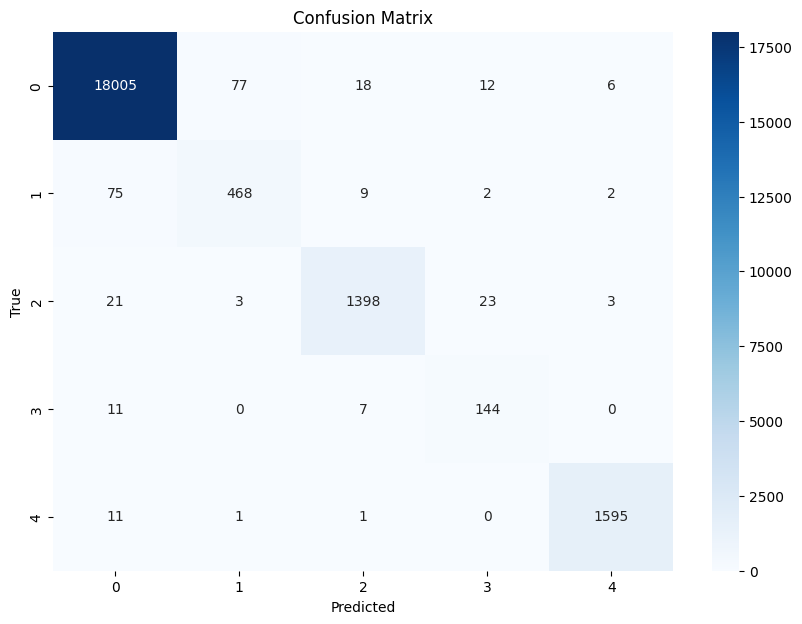

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test_np, predicted)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [26]:
torch.save(model.state_dict(), 'ecg_model.pth')

loaded_model = ECG_CNN(num_classes)
loaded_model.load_state_dict(torch.load('ecg_model.pth'))
loaded_model.to(device)

ECG_CNN(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_pool): AdaptiveAvgPool1d(output_size=20)
  (fc1): Linear(in_features=5120, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)